In [1]:
from IPython import display

from utils import Logger

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets


2023-10-27 10:54:38.038446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 10:54:38.129657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-27 10:54:38.129673: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-27 10:54:38.146930: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 10:54:39.054288: W tensorflow/stream_executor/platform/de

In [2]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'


In [3]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)


In [4]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)


100%|██████████| 9912422/9912422 [00:00<00:00, 13205127.87it/s]


Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82856151.73it/s]

Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8998072.33it/s]


Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]

Extracting ./torch_data/DCGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/DCGAN/MNIST/dataset/MNIST/raw



In [5]:
#Discriminative neural network model, classifies input data into one of two classes (real vs fake).
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        #4 convolutional layers that learn hierarchical features from the input data.  Each layer has a LeakyReLU activation function, which makes them nonlinear.
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #Convolution layers 2-4 applies batch normalization to help stabilize and accelerate the training of the NN
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #After the conv layers, the data is flattened and passed through a fully connected (linear) layer.  This reduces the high-dimensional feature maps to a single output value followed by a sigmoid activation function.
        #This is the probability of the input data belonging to one of the two classes.
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    #Forward pass, applies the 4 convolution layers and flattened output layer.
    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x


In [6]:
#Model that generates the synthetic data.
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        #Layer takes in an input and projects it to a higher dimensional space (1024*4*4)
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        #4 transposed convolutional layers (upsampling layers), gradually increases the spatial dimensions of the data and reduce the number of channels.
        #Batch normalization is applied to layers 1-3 to stabilize the nn.  ReLU activation function is used.
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        #Final convolutional layer produces the final generated output.
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )

        #output passed through a hyperbolic tangent activation function which scales the output values between -1 and 1.
        self.out = torch.nn.Tanh()

    #Forward pass
    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise - Adds random noise as input for the generated data.
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n



In [7]:
#Initialize weights of convolution and bath normalization layers.
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)


In [10]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [11]:
# Optimizers - Adam
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

In [12]:
#Create tensors containing ones and zeroes for real and fake data respectively.
#Provides a target label for the discriminator model to compute the loss.
#The generator will try to produce that is indistinguishable from the real data, while the discriminator model will try to classify whether the input data is real of fake.
#They both will use these labels to compute the loss for both the real and fake samples during training.
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


In [13]:
#Training models
#These functions will be used alternatingly to update the discriminator and generator models to improve the generator's ability to produce realistic data while also improving the discriminator's abilty to distinguish between real and fake data.

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error


In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)

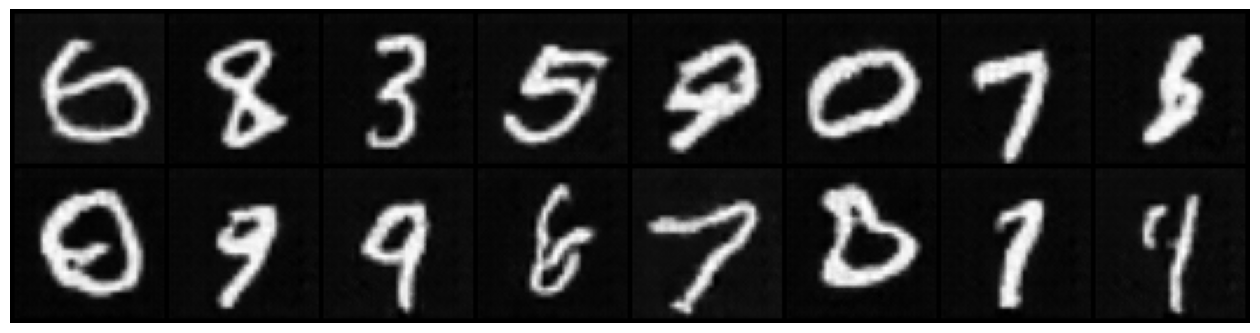

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.2525, Generator Loss: 2.9094
D(x): 0.9815, D(G(z)): 0.1924


In [15]:
#Training loop.
#Alternates between updating the discrimnator and the generator models.

logger = Logger(model_name='DCGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
